In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime

from matplotlib import pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import pacf, acf

from statsmodels.tsa.stattools import adfuller
from utils import *

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('data/AAPL.csv', delimiter=',').reset_index()[['date','close']]

df['date'] = pd.to_datetime(df['date']).dt.date
df['close'] = df['close'] / np.abs(df['close']).max()
df.rename(columns={'close':'value'},inplace=True)

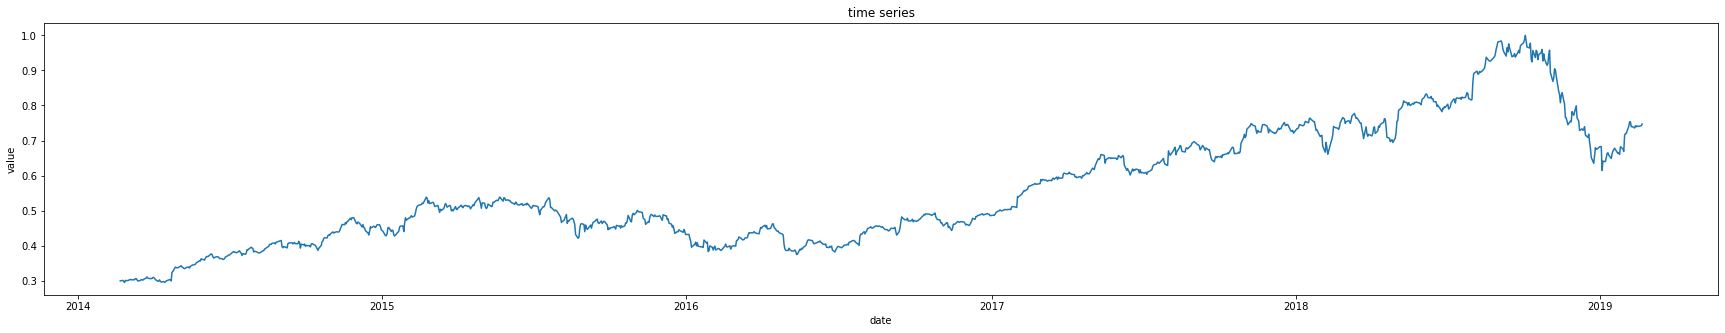

In [3]:
# Plot time series
plt.figure(figsize=(30, 5))
plt.title("time series")
plt.plot(df["date"], df['value'])
plt.xlabel("date")
plt.ylabel("value")
plt.show()

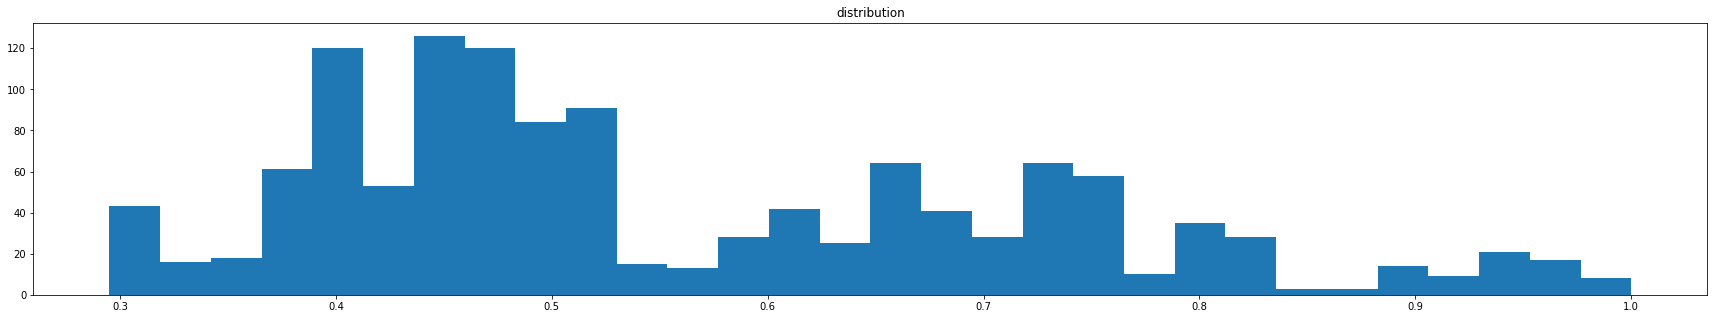

In [4]:
# Plot distribution histogram
plt.figure(figsize=(30, 5))
plt.title(f"distribution")
plt.hist(df['value'], bins=30)
plt.show()

# Check stacionarity

In [5]:
stationarity_test(df['value'], adfuller)

{'adfuller_statistics': -1.2893165741528076,
 'adfuller_p_value': 0.6340457103509508,
 'adfuller_critical_value (1%)': -3.4355964295197743,
 'adfuller_critical_value (5%)': -2.863856825923603,
 'adfuller_critical_value (10%)': -2.5680035060041626}

In [6]:
stationarity_test(df['value'], kpss)

{'kpss_statistics': 4.232637204768242,
 'kpss_p_value': 0.01,
 'kpss_critical_value (10%)': 0.347,
 'kpss_critical_value (5%)': 0.463,
 'kpss_critical_value (2.5%)': 0.574,
 'kpss_critical_value (1%)': 0.739}

# Seasonal decomposition

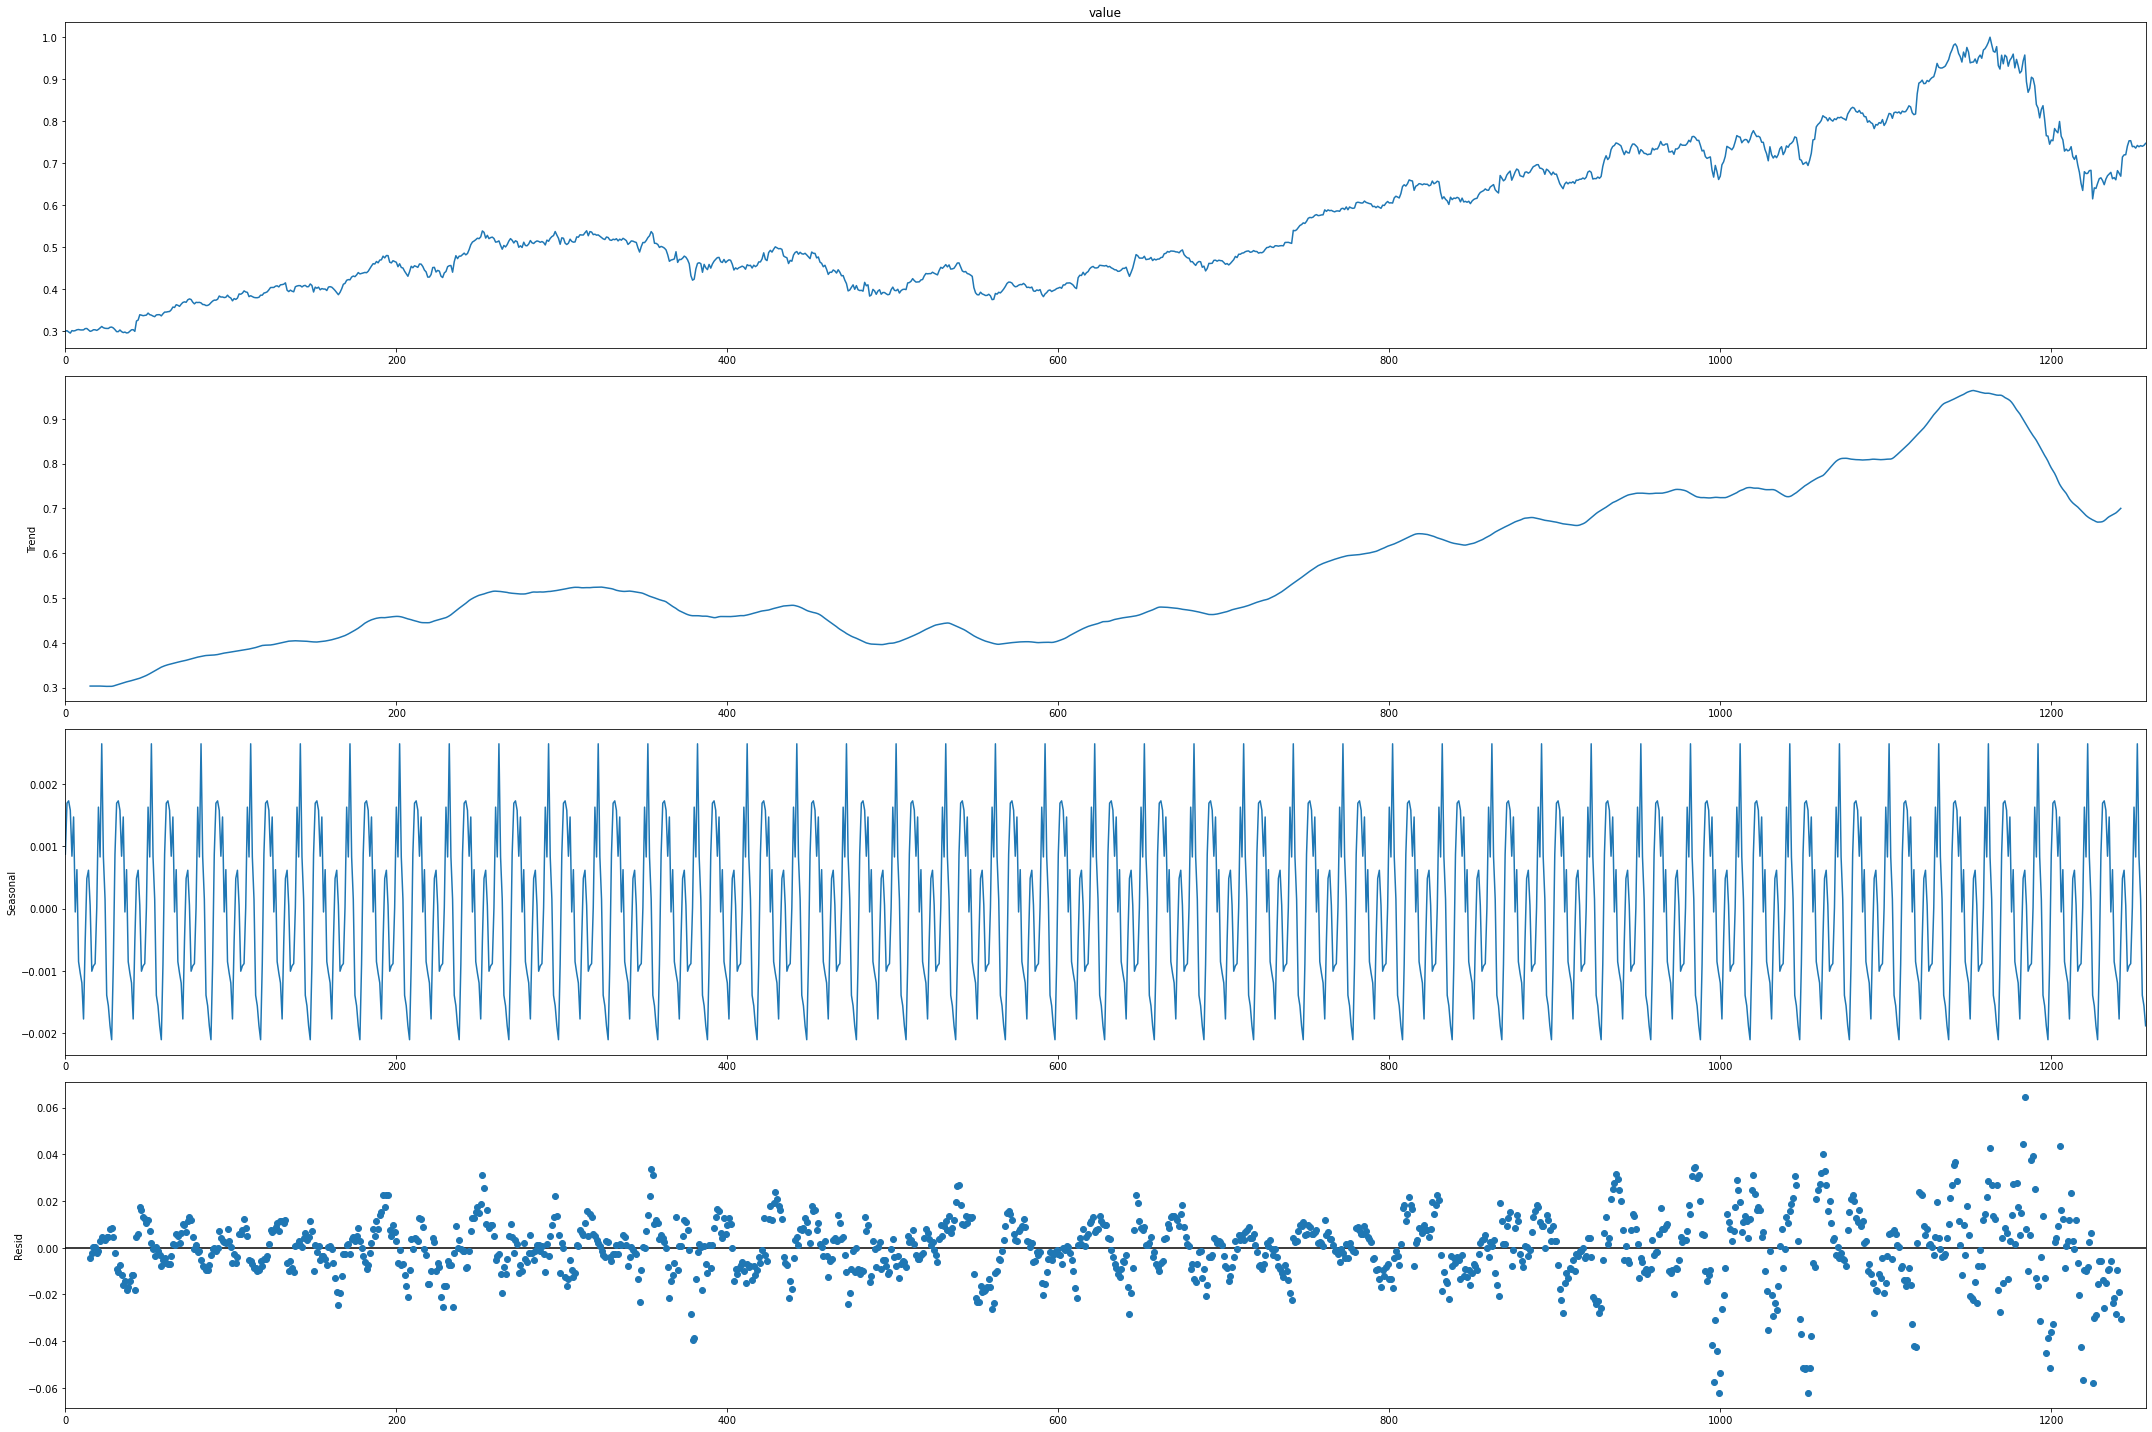

In [7]:
plt.rcParams.update({'figure.figsize': (30,20)})
sesonal_dec = seasonal_decompose(df['value'], period=30)
sesonal_dec.plot()
plt.show()

In [8]:
stationary_series = lambda x: np.log1p(x).diff(1).dropna().diff(1).dropna()

reverse_series = lambda x,y: pd.Series(\
                             np.exp(np.r_[np.log1p(y).iloc[-2], \
                             np.r_[np.log1p(y).diff(1).dropna().iloc[-1], \
                        x.dropna()].cumsum()].cumsum())-1)

reversed_partial = lambda x,y: np.exp(y.shift(2).fillna(y.iloc[0])+\
                            y.diff(1).shift(1).fillna(y.diff(1)).fillna(0)*2+\
                          x.fillna(0))-1

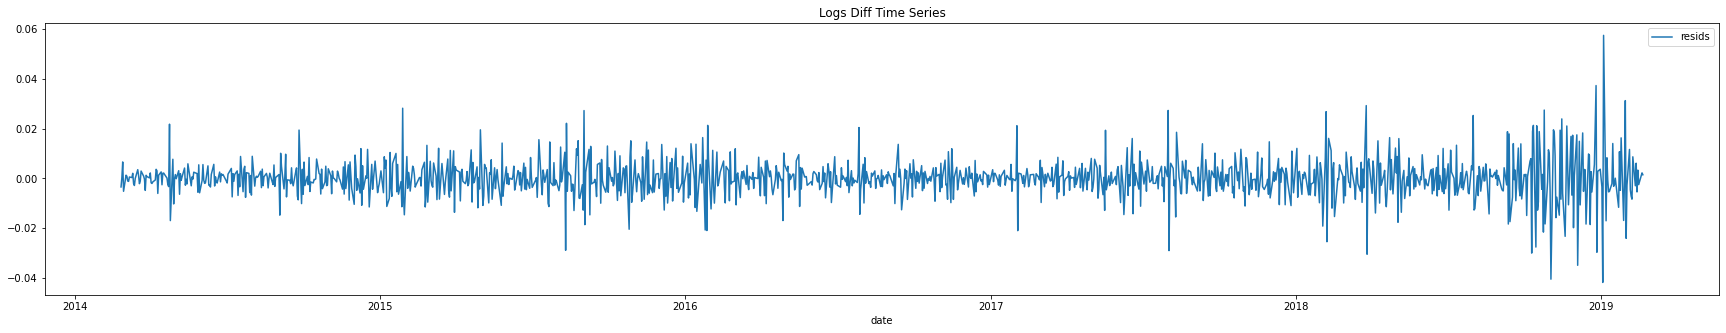

In [9]:
resids = stationary_series(df['value']).reset_index(drop=True)

df['resids'] = np.r_[[np.nan]*2,resids]

df['reversed'] = reverse_series(df['resids'], df['value'][:2])

df['reversed_partial'] = reversed_partial(df['resids'], np.log1p(df['value']))

df.plot(x='date',y='resids', title = 'Logs Diff Time Series', figsize=(30, 5))
plt.show()

In [10]:
stationarity_test(resids, adfuller)

{'adfuller_statistics': -13.526385408482458,
 'adfuller_p_value': 2.6734909139442393e-25,
 'adfuller_critical_value (1%)': -3.435660336370594,
 'adfuller_critical_value (5%)': -2.863885022214541,
 'adfuller_critical_value (10%)': -2.568018522153254}

In [11]:
stationarity_test(resids, kpss)

{'kpss_statistics': 0.010153239414407435,
 'kpss_p_value': 0.1,
 'kpss_critical_value (10%)': 0.347,
 'kpss_critical_value (5%)': 0.463,
 'kpss_critical_value (2.5%)': 0.574,
 'kpss_critical_value (1%)': 0.739}

# ACF/PACF

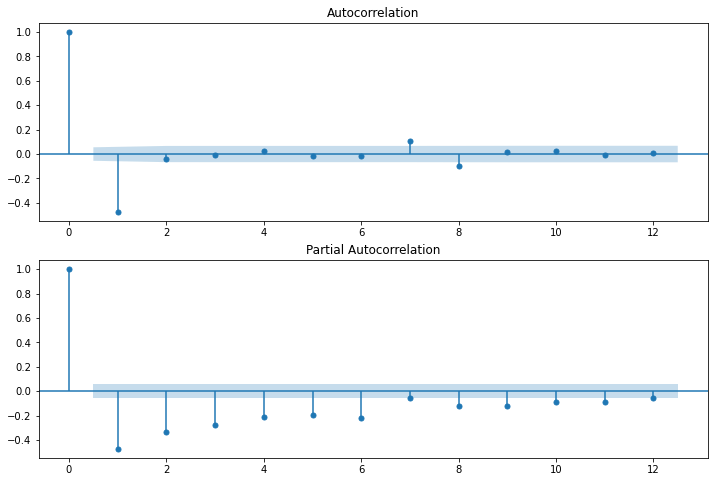

In [12]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resids, lags=12, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resids, lags=12, ax=ax2)

In [13]:
ts_pacf = pacf(resids, nlags=12)

n_AR = next(x[0] for x in enumerate(ts_pacf) if abs(x[1]) < 0.1)-1

print(ts_pacf, '\n\nAR range =', n_AR)

[ 1.         -0.4717234  -0.33723918 -0.27715326 -0.2120335  -0.19693742
 -0.21846738 -0.05786532 -0.11878304 -0.1214849  -0.08707824 -0.08461365
 -0.05512579] 

AR range = 6


# Train/Test split

In [14]:
test_size = 7

train_size = (df['date'].iloc[-1] - df['date'].iloc[2]).days - test_size

print(f"Test period {test_size}\nTrain period {train_size}")

folds_indexes = list(TimeSeriesSplit(n_splits=5, test_size=test_size).split(resids))
min_fold_len = min([len(fold[0]) for fold in folds_indexes])

for i in range(len(folds_indexes)):
    folds_indexes[i] = (folds_indexes[i][0][-min_fold_len:], folds_indexes[i][1])

Test period 7
Train period 1814


# ARMA

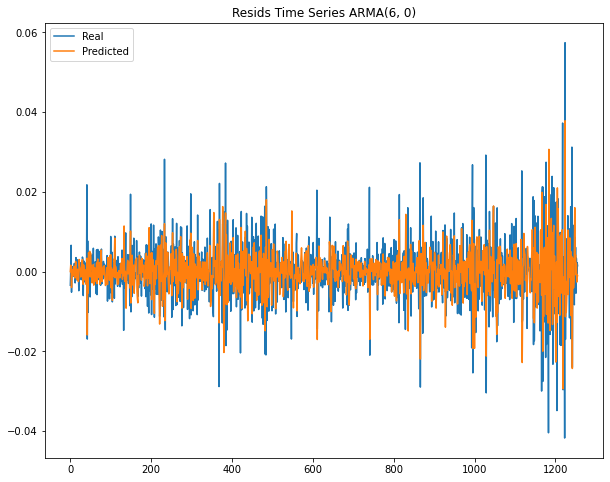

R2 for 0 MA lags = 0.44165249339726054


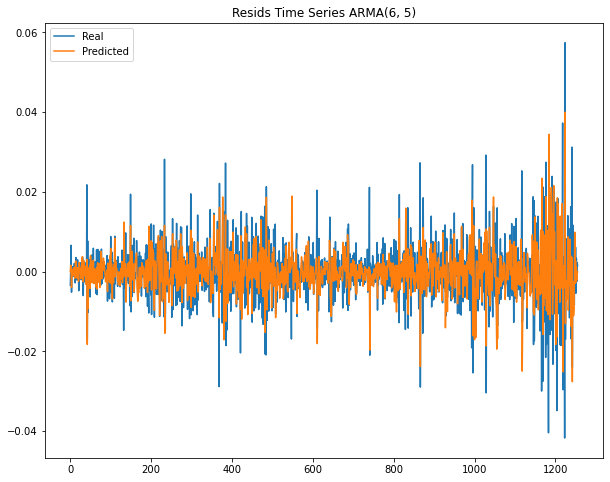

R2 for 5 MA lags = 0.49916487920794783


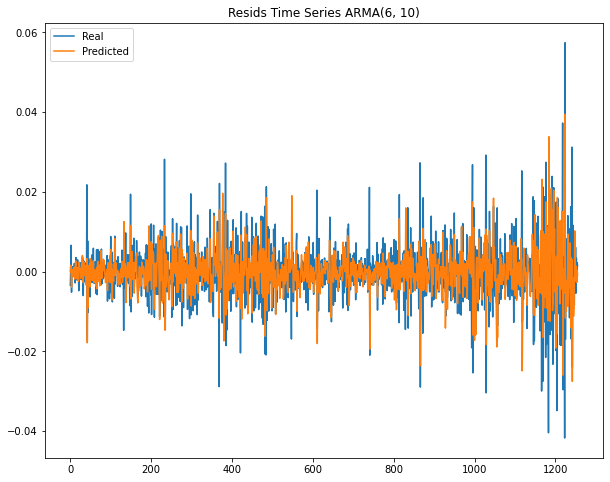

R2 for 10 MA lags = 0.4976673973903216


In [15]:
models = []
for i in range(3):
    model = ARMA(resids, order=(n_AR, i*5))
    model_fit = model.fit()
    models.append(model)
    simple_plot(resids, model_fit.fittedvalues, legend=['Real','Predicted'], title=f'Resids Time Series ARMA({n_AR}, {i*5})')
    print(f'R2 for {i*5} MA lags =', r2_score(resids, model_fit.fittedvalues))
    

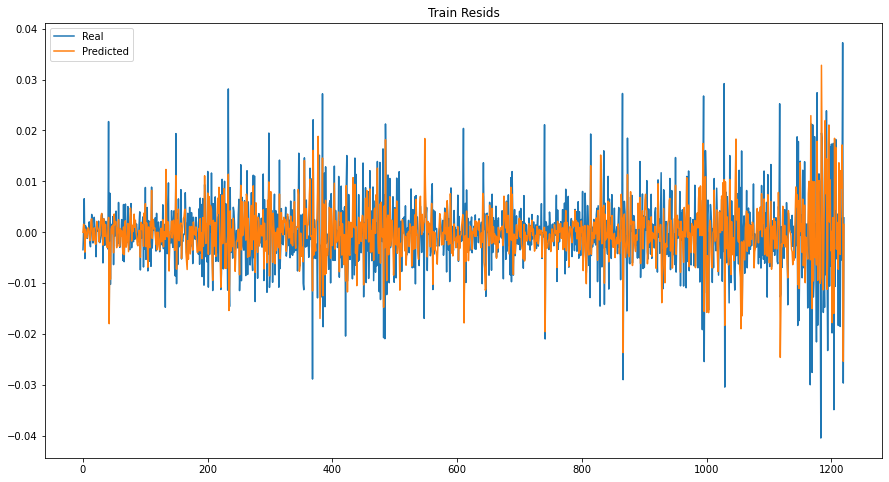

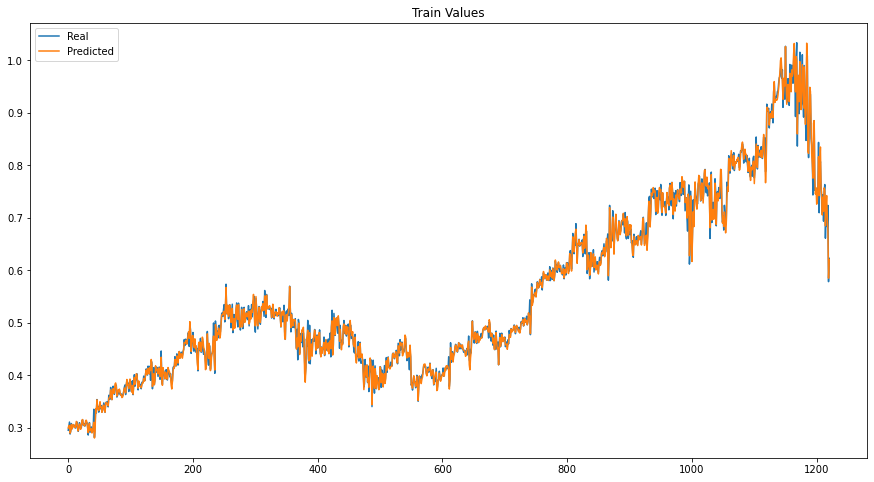

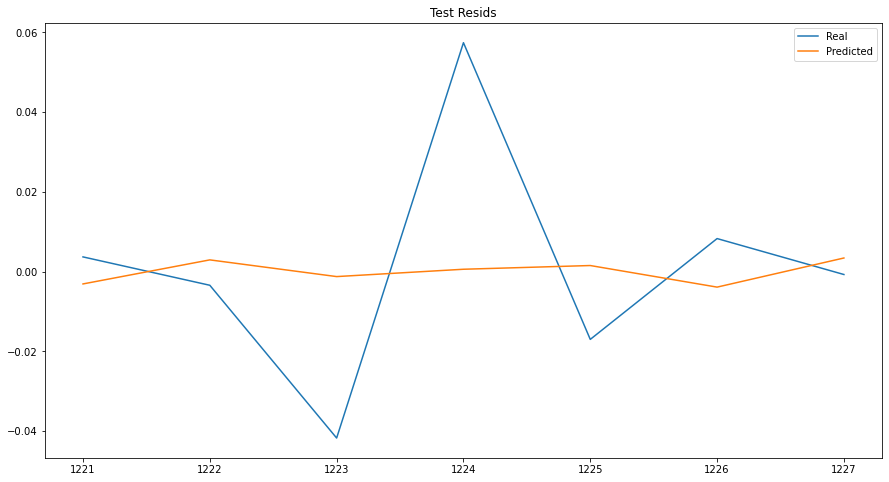

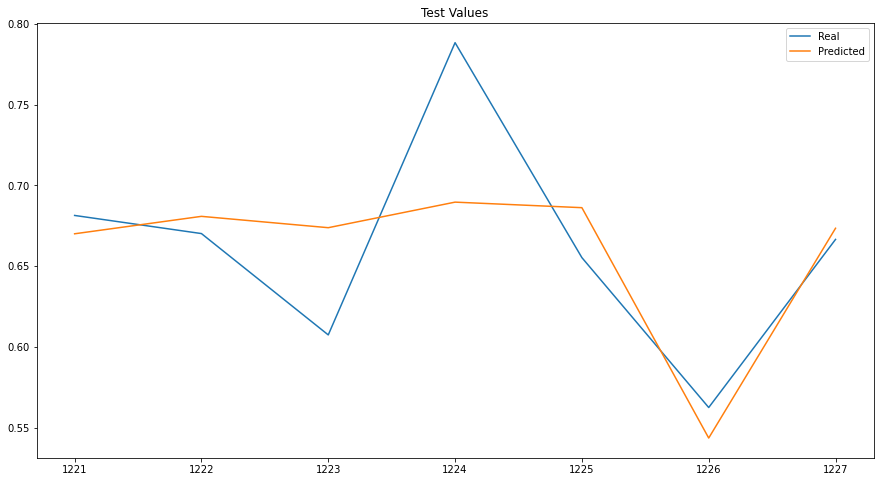

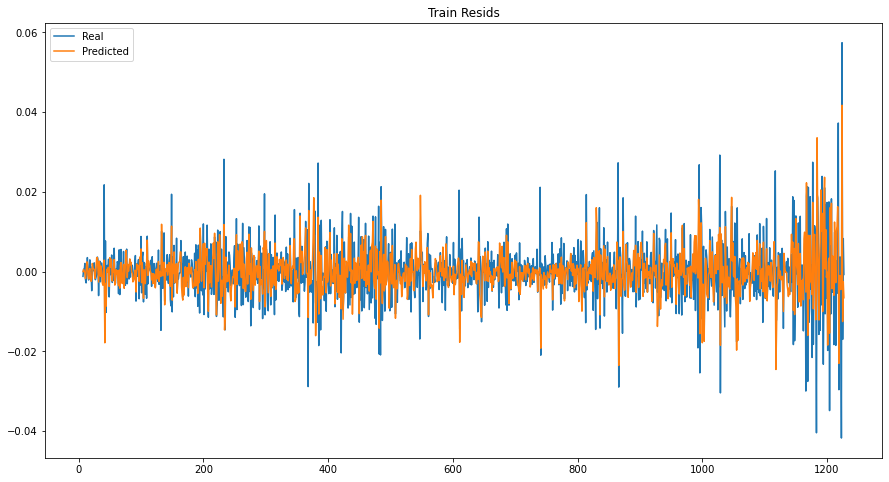

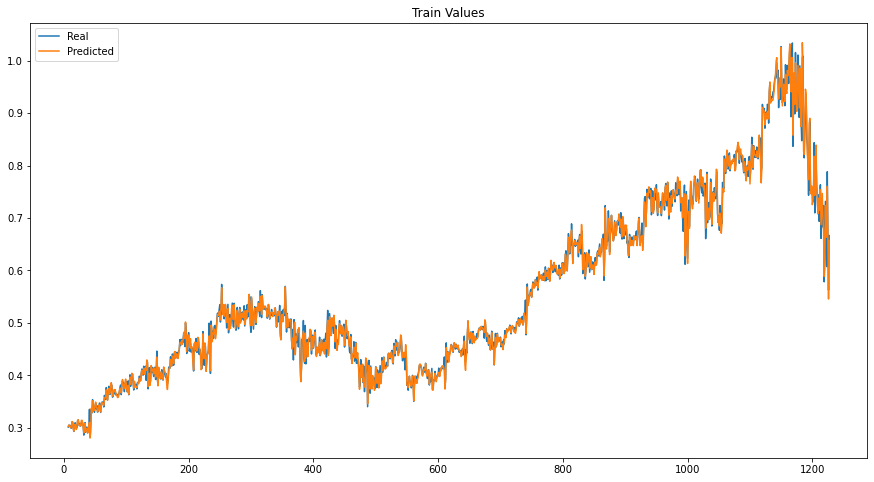

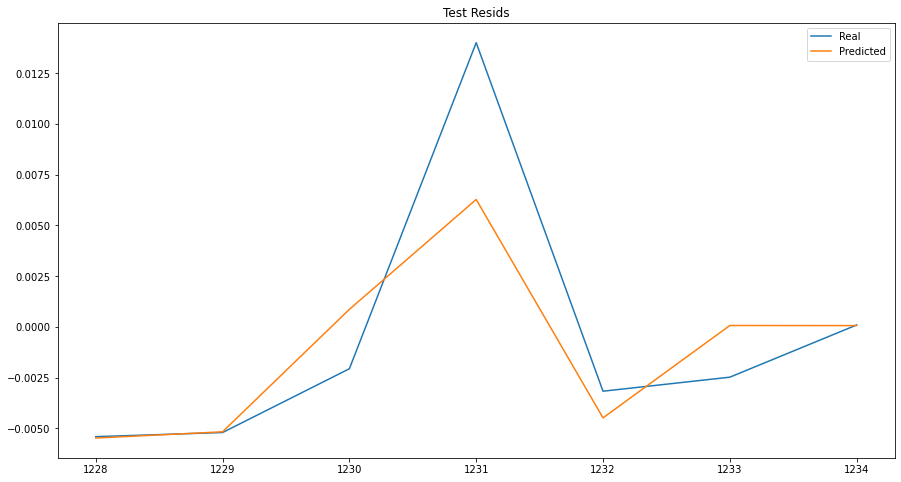

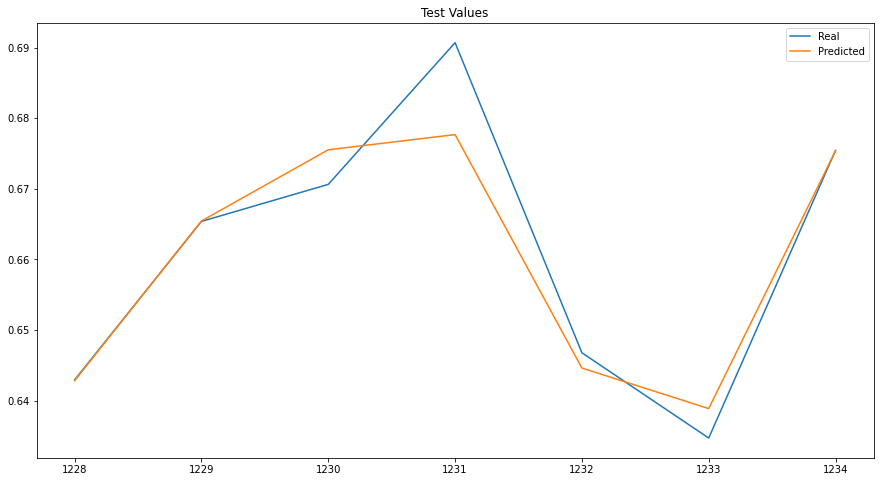

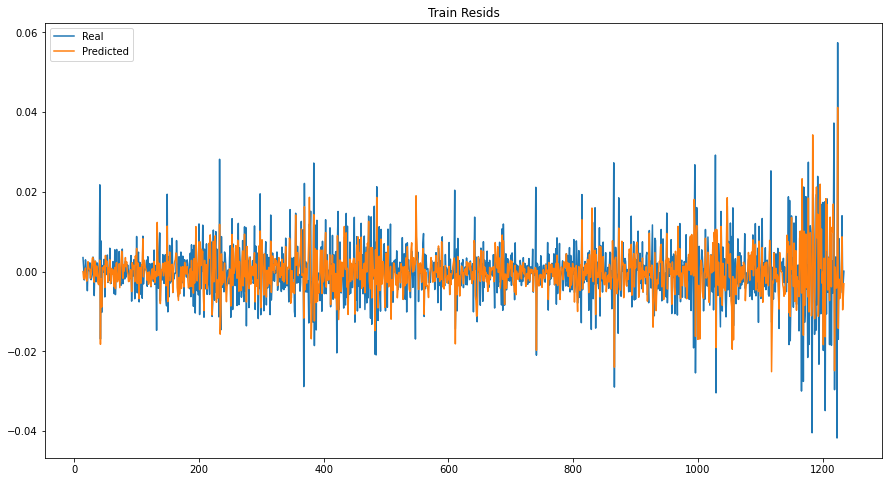

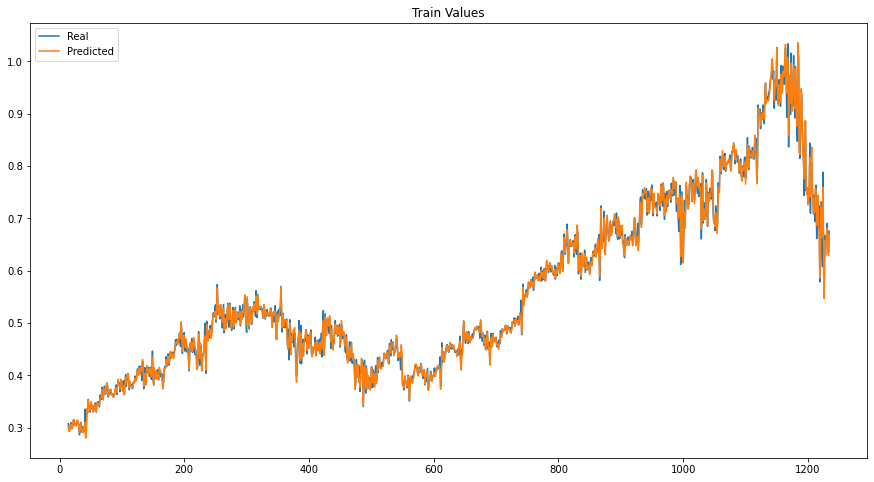

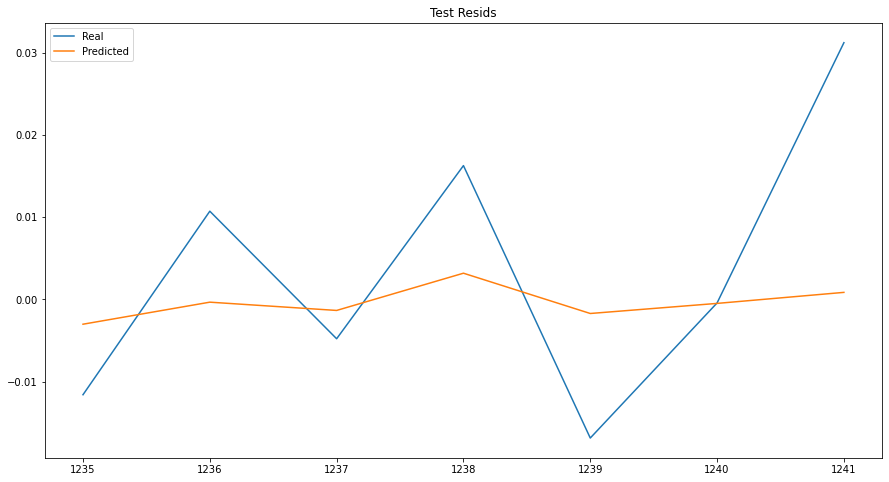

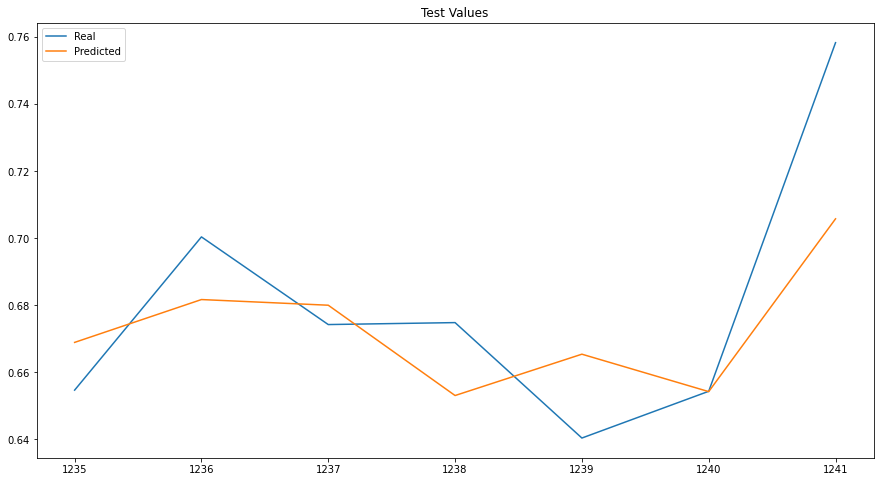

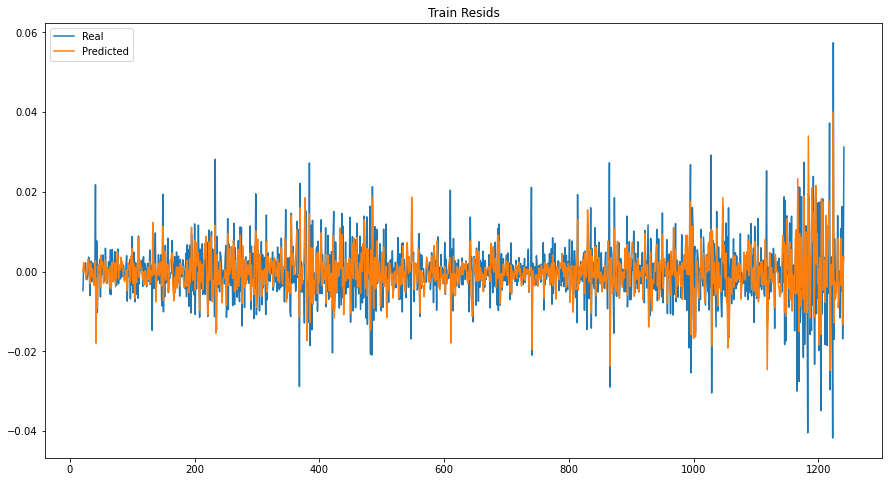

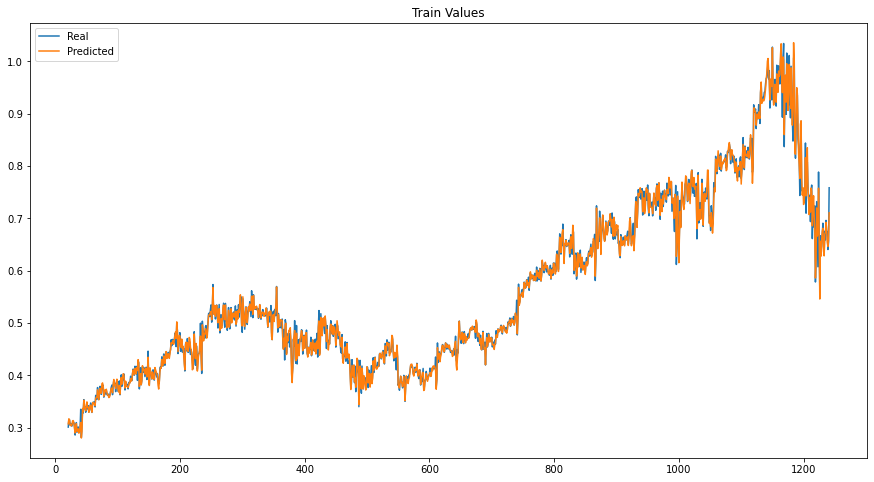

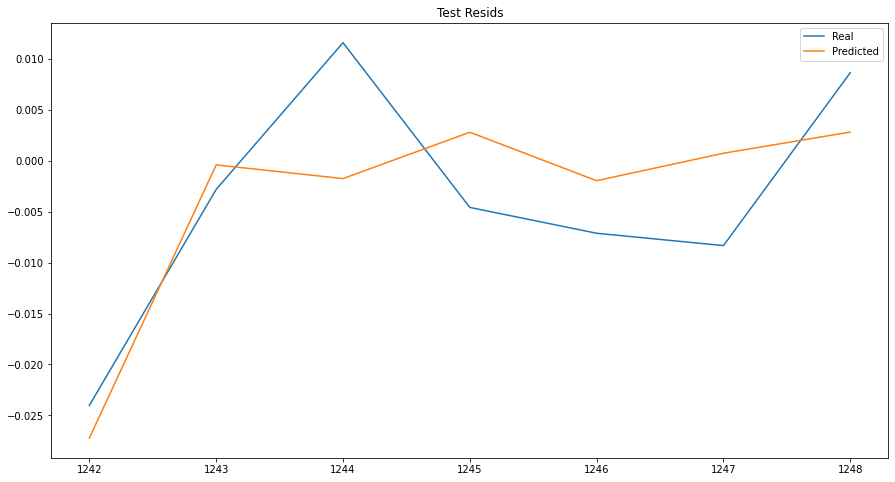

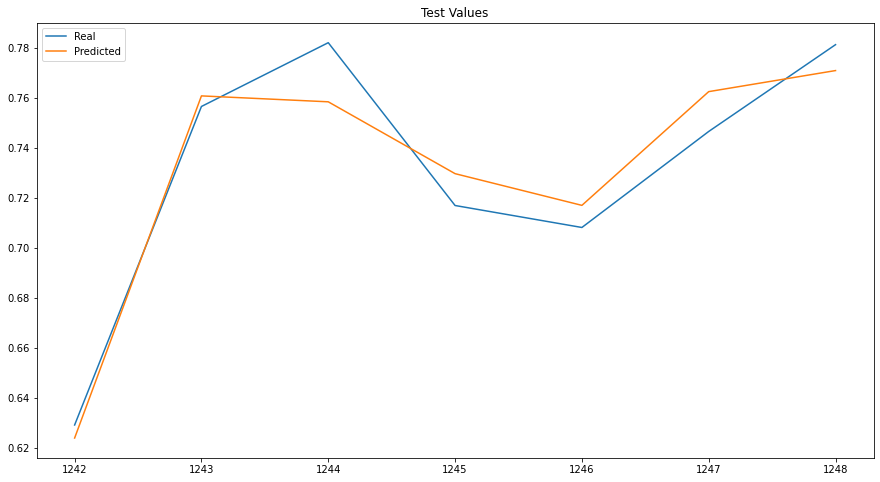

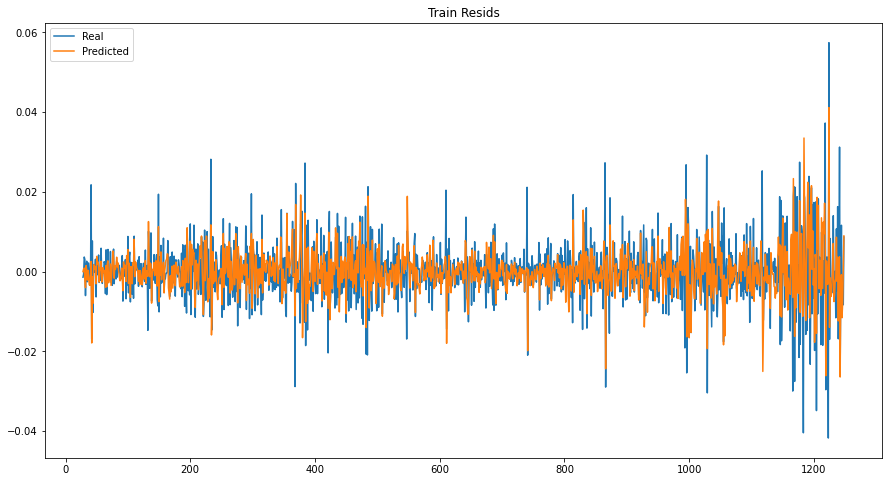

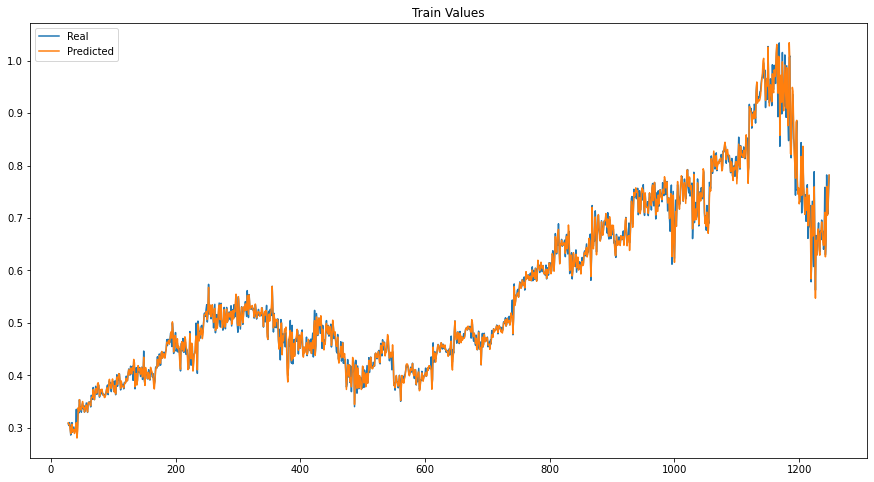

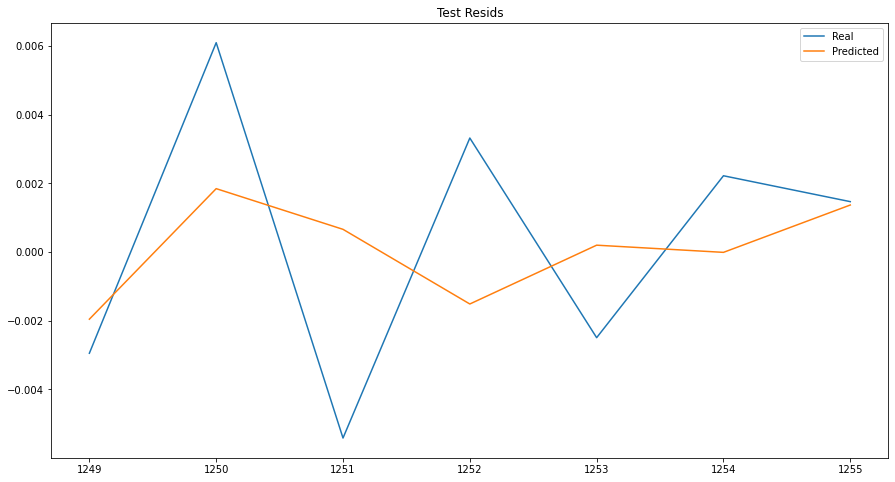

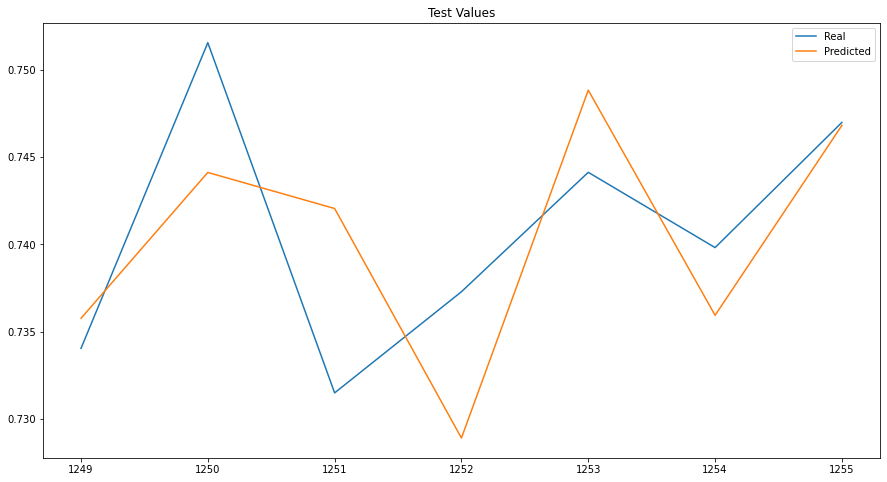

In [16]:
n_MA = 5

metrics_df_train = pd.DataFrame()
metrics_df_test = pd.DataFrame()

for e, fold in enumerate(folds_indexes):
    
    metrics_train = pd.DataFrame()
    metrics_test = pd.DataFrame()

    train = resids.iloc[fold[0]]
    test = resids.iloc[fold[1]]
    
    model = ARMA(train, order=(n_AR, n_MA))
    
    model_fit = model.fit()
    
#         AR = predict(model_fit.arparams, train, test_size)

#         MA = predict(model_fit.maparams, model_fit.resid, test_size)
    
    prediction = pd.Series(model_fit.forecast(test_size)[0], index=test.index)

    simple_plot(train, model_fit.fittedvalues, legend=['Real','Predicted'], title='Train Resids', figsize=(15,8))
    
    simple_plot(reversed_partial(train, np.log1p(df['value']).iloc[fold[0]]), reversed_partial(model_fit.fittedvalues, np.log1p(df['value']).iloc[fold[0]]), legend=['Real','Predicted'], title='Train Values', figsize=(15,8))
    
    simple_plot(test, prediction, legend=['Real','Predicted'], title='Test Resids', figsize=(15,8))
    
    simple_plot(reversed_partial(test, np.log1p(df['value']).iloc[fold[1]]), reversed_partial(prediction, np.log1p(df['value']).iloc[fold[1]]), legend=['Real','Predicted'], title='Test Values', figsize=(15,8))
    
    metrics_train = metrics_train.append(calculate_metrics(model_fit.fittedvalues, train),ignore_index=True)
    metrics_test = metrics_test.append(calculate_metrics(prediction, test),ignore_index=True)
    
    metrics_train['DW'] = durbin_watson(model_fit.resid)
    metrics_train['AIC'] = model_fit.aic
    metrics_train['BIC'] = model_fit.bic
    
    metrics_train['fold'] = e
    metrics_test['fold'] = e
    
    metrics_df_train = metrics_df_train.append(metrics_train)
    metrics_df_test = metrics_df_test.append(metrics_test.drop(columns=['R2']))
    

In [17]:
metrics_df_train.groupby(lambda _: True).mean().drop(columns=['fold'])

,MAE,MSE,R2,RMSE,RSS,DW,AIC,BIC
True,0.003835,0.000031,0.494953,0.005564,0.037804,2.010899,-9183.689173,-9117.292642


In [18]:
metrics_df_test.groupby(lambda _: True).mean().drop(columns=['fold'])

,MAE,MSE,RMSE,RSS
True,0.008833,0.000216,0.011422,0.001509
